In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import gc
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression

from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [5]:
aggregated_data = pd.read_csv("/content/drive/MyDrive/zindi/aggday.csv")
ss = pd.read_excel("/content/drive/MyDrive/zindi/Kalam Climate Data.xlsx")

In [6]:
# Find the minimum and maximum date_time values
min_date = aggregated_data['Date'].min()
max_date = aggregated_data['Date'].max()

print(f"Minimum date_time: {min_date}")
print(f"Maximum date_time: {max_date}")

Minimum date_time: 2023-06-03
Maximum date_time: 2024-09-23


In [7]:
# Fill missing date values with 0 kwh

# Create a date range
date_rng = pd.date_range(start=min_date, end=max_date, freq='D')

# Create an empty DataFrame to store the complete data
complete_data = pd.DataFrame()

# Iterate through each unique 'Source'
for source in aggregated_data['Source'].unique():
    # Extract data for the current 'Source'
    source_data = aggregated_data[aggregated_data['Source'] == source].copy()

    # Convert the source data Date to match the type of date_rng
    source_data['Date'] = pd.to_datetime(source_data['Date'])

    # Create a complete date range for the current 'Source'
    source_date_rng = pd.DataFrame({'Date': date_rng})
    source_date_rng['Source'] = source

    # Merge with the existing data, filling missing 'kwh' values with 0
    source_data = pd.merge(source_date_rng, source_data, on=['Date', 'Source'], how='left')
    # source_data['kwh'] = source_data['kwh'].fillna(0)
    source_data = source_data.dropna()
    # Append to the complete data
    complete_data = pd.concat([complete_data, source_data], ignore_index=True)

In [9]:
### CHANGE NAME OF FOLDER AND FILES TO CORRESPOND ####
climate_df = pd.read_excel("/content/drive/MyDrive/zindi/Kalam Climate Data.xlsx")# Convert to datetime
complete_data["Date"] = pd.to_datetime(complete_data["Date"])
climate_df["Date Time"] = pd.to_datetime(climate_df["Date Time"])

# Aggregate climate data to daily level
climate_daily = climate_df.groupby(climate_df["Date Time"].dt.date).agg({
    "Temperature (°C)": "mean",
    "Dewpoint Temperature (°C)": "mean",
    "U Wind Component (m/s)": "mean",
    "V Wind Component (m/s)": "mean",
    "Total Precipitation (mm)": "sum",
    "Snowfall (mm)": "sum",
    "Snow Cover (%)": "mean",
}).reset_index()

# Convert 'Date' column in climate_daily to datetime format
climate_daily.rename(columns={"Date Time": "Date"}, inplace=True)
climate_daily["Date"] = pd.to_datetime(climate_daily["Date"])  # Ensure datetime64[ns]

# Merge with complete_data
complete_data = complete_data.merge(climate_daily, on="Date", how="left")

In [10]:
complete_data.head()

,Date,Source,kwh,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%)
0,2024-07-22,consumer_device_10_data_user_1,0.024330,14.719596,8.280669,0.022655,-0.104998,0.073049,0.0,0.0
1,2024-07-23,consumer_device_10_data_user_1,0.103560,13.217268,9.862700,0.116137,-0.077997,0.121921,0.0,0.0
2,2024-07-24,consumer_device_10_data_user_1,0.137543,12.462190,9.865658,0.103451,-0.075028,0.119984,0.0,0.0
3,2024-07-25,consumer_device_10_data_user_1,0.121011,13.867551,8.973798,0.066345,-0.043182,0.034283,0.0,0.0
4,2024-07-26,consumer_device_10_data_user_1,0.000000,15.572609,9.434734,0.093025,0.046414,0.006961,0.0,0.0


In [11]:
# Extract consumer device and data user using regex
complete_data["consumer_device"] = complete_data["Source"].str.extract(r'consumer_device_(\d+)_data_user_\d+').astype(int)
complete_data["data_user"] = complete_data["Source"].str.extract(r'consumer_device_\d+_data_user_(\d+)').astype(int)

In [12]:
import pandas as pd

# Convert 'Date' to datetime format if not already
complete_data["Date"] = pd.to_datetime(complete_data["Date"])

# Extract date features
complete_data["year"] = complete_data["Date"].dt.year
complete_data["month"] = complete_data["Date"].dt.month
complete_data["day"] = complete_data["Date"].dt.day
complete_data["day_of_week"] = complete_data["Date"].dt.dayofweek  # Monday=0, Sunday=6
complete_data["week_of_year"] = complete_data["Date"].dt.isocalendar().week
complete_data["quarter"] = complete_data["Date"].dt.quarter
complete_data["is_weekend"] = (complete_data["day_of_week"] >= 5).astype(int)  # 1 if Sat/Sun, else 0

In [13]:
complete_data = complete_data.drop(columns=['data_user'])


In [14]:
complete_data['consumer_device']= complete_data['consumer_device'].astype(str)


In [15]:
# Charger les CSV
df_voltage = pd.read_csv("/content/drive/MyDrive/zindi/source_to_voltage.csv")
df_type_voltage = pd.read_csv("/content/drive/MyDrive/zindi/source_to_type_voltage.csv")

# Fusionner avec df3 (qui contient 'Source')
complete_data = complete_data.merge(df_voltage, on='Source', how='left')
complete_data =complete_data.merge(df_type_voltage, on='Source', how='left')

In [16]:
complete_data=complete_data.dropna()

In [17]:
devices_to_remove = [
    "consumer_device_1",
    "consumer_device_7",
    "consumer_device_19",
    "consumer_device_20",
    "consumer_device_38",
    "consumer_device_39"
]

# Suppression des lignes
complete_data = complete_data[~complete_data["consumer_device"].isin(devices_to_remove)]


In [ ]:

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
def df_to_X_y2(df, window_size=30):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

In [111]:
df=complete_data[complete_data['Source']=='consumer_device_37_data_user_7']

In [112]:
complete_data.columns

Index(['Date', 'Source', 'kwh', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'consumer_device', 'year', 'month', 'day',
       'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'Voltage',
       'Type_Voltage'],
      dtype='object')

In [113]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%s')
temp = df[['kwh', 'Temperature (°C)',
      'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
      'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
      'Snow Cover (%)'   ]].copy()
temp_df = temp.copy()
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df = temp_df.drop('Seconds', axis=1)
X2, y2 = df_to_X_y2(temp_df,20)
X2.shape, y2.shape


((339, 20, 12), (339,))

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 64)                  │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0659 - root_mean_squared_error: 0.2533 - val_loss: 0.2374 - val_root_mean_squared_error: 0.4873
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0247 - root_mean_squared_error: 0.1540 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0189 - root_mean_squared_error: 0.1277 - val_loss: 0.2370 - val_root_mean_squared_error: 0.4869
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0143 - root_mean_squared_error: 0.1065 - val_loss: 0.2241 - val_root_mean_squared_error: 0.4734
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0111 - root_mean_squared_error: 0.0925 - val_loss: 0.2254 - val_root_mean_squared_error: 0.4748
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0110 - root_mean_squared_error: 0.0910 - val_loss: 0.2205 - val_root_mean_squared_error: 0.4696
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss:

(    Predictions   Actuals
 0      0.151831  0.000409
 1      0.166447  0.000141
 2      0.102685  0.005495
 3      0.040167  0.007396
 4      0.013565  0.013002
 5      0.026027  0.000000
 6     -0.024224  0.000000
 7      0.023478  0.000202
 8      0.051908  0.000000
 9     -0.016454  0.000000
 10    -0.080979  0.026808
 11    -0.007746  0.044539
 12     0.123277  0.646289
 13     0.114550  0.006990
 14     0.069946  0.008050
 15     0.070441  0.012042
 16     0.069117  0.000000
 17     0.023362  0.000000
 18     0.009538  0.027071
 19     0.084441  0.048189
 20     0.113408  0.055273
 21     0.016613  0.070990
 22    -0.055815  0.014712
 23    -0.058830  0.000000
 24    -0.069217  0.000000
 25    -0.032752  0.000000
 26     0.060968  0.000000
 27     0.104363  0.000000
 28     0.130031  0.000000
 29     0.127708  0.000000,
 0.014932916512519224)

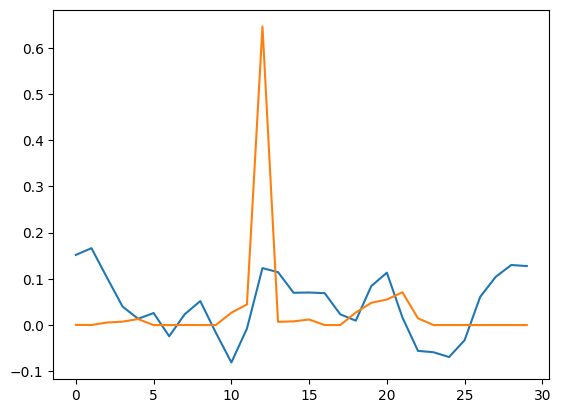

In [114]:
tr=X2.shape[0]-50
ival= X2.shape[0] -30

X2_train, y2_train = X2[:tr], y2[:tr]
X2_val, y2_val = X2[tr:ival], y2[tr:ival]
X2_test, y2_test = X2[ival:], y2[ival:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
print("")


model4 = Sequential()
model4.add(InputLayer((X2_train.shape[1], X2_train.shape[2])))
model4.add(LSTM(64))
model4.add(Dense(32, 'relu'))
model4.add(Dense(16, 'relu'))

model4.add(Dense(1, 'linear'))

model4.summary()

# Compiler le modèle
model4.compile(loss=MeanSquaredError(),
              optimizer=Adam(learning_rate=0.001),
              metrics=[RootMeanSquaredError()])

model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10)
plot_predictions1(model4, X2_test, y2_test)